In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots

torch.manual_seed(40)

plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300

c:\Users\Julian\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== Distribución Prior ===
BoxUniform(Uniform(low: torch.Size([6]), high: torch.Size([6])), 1)


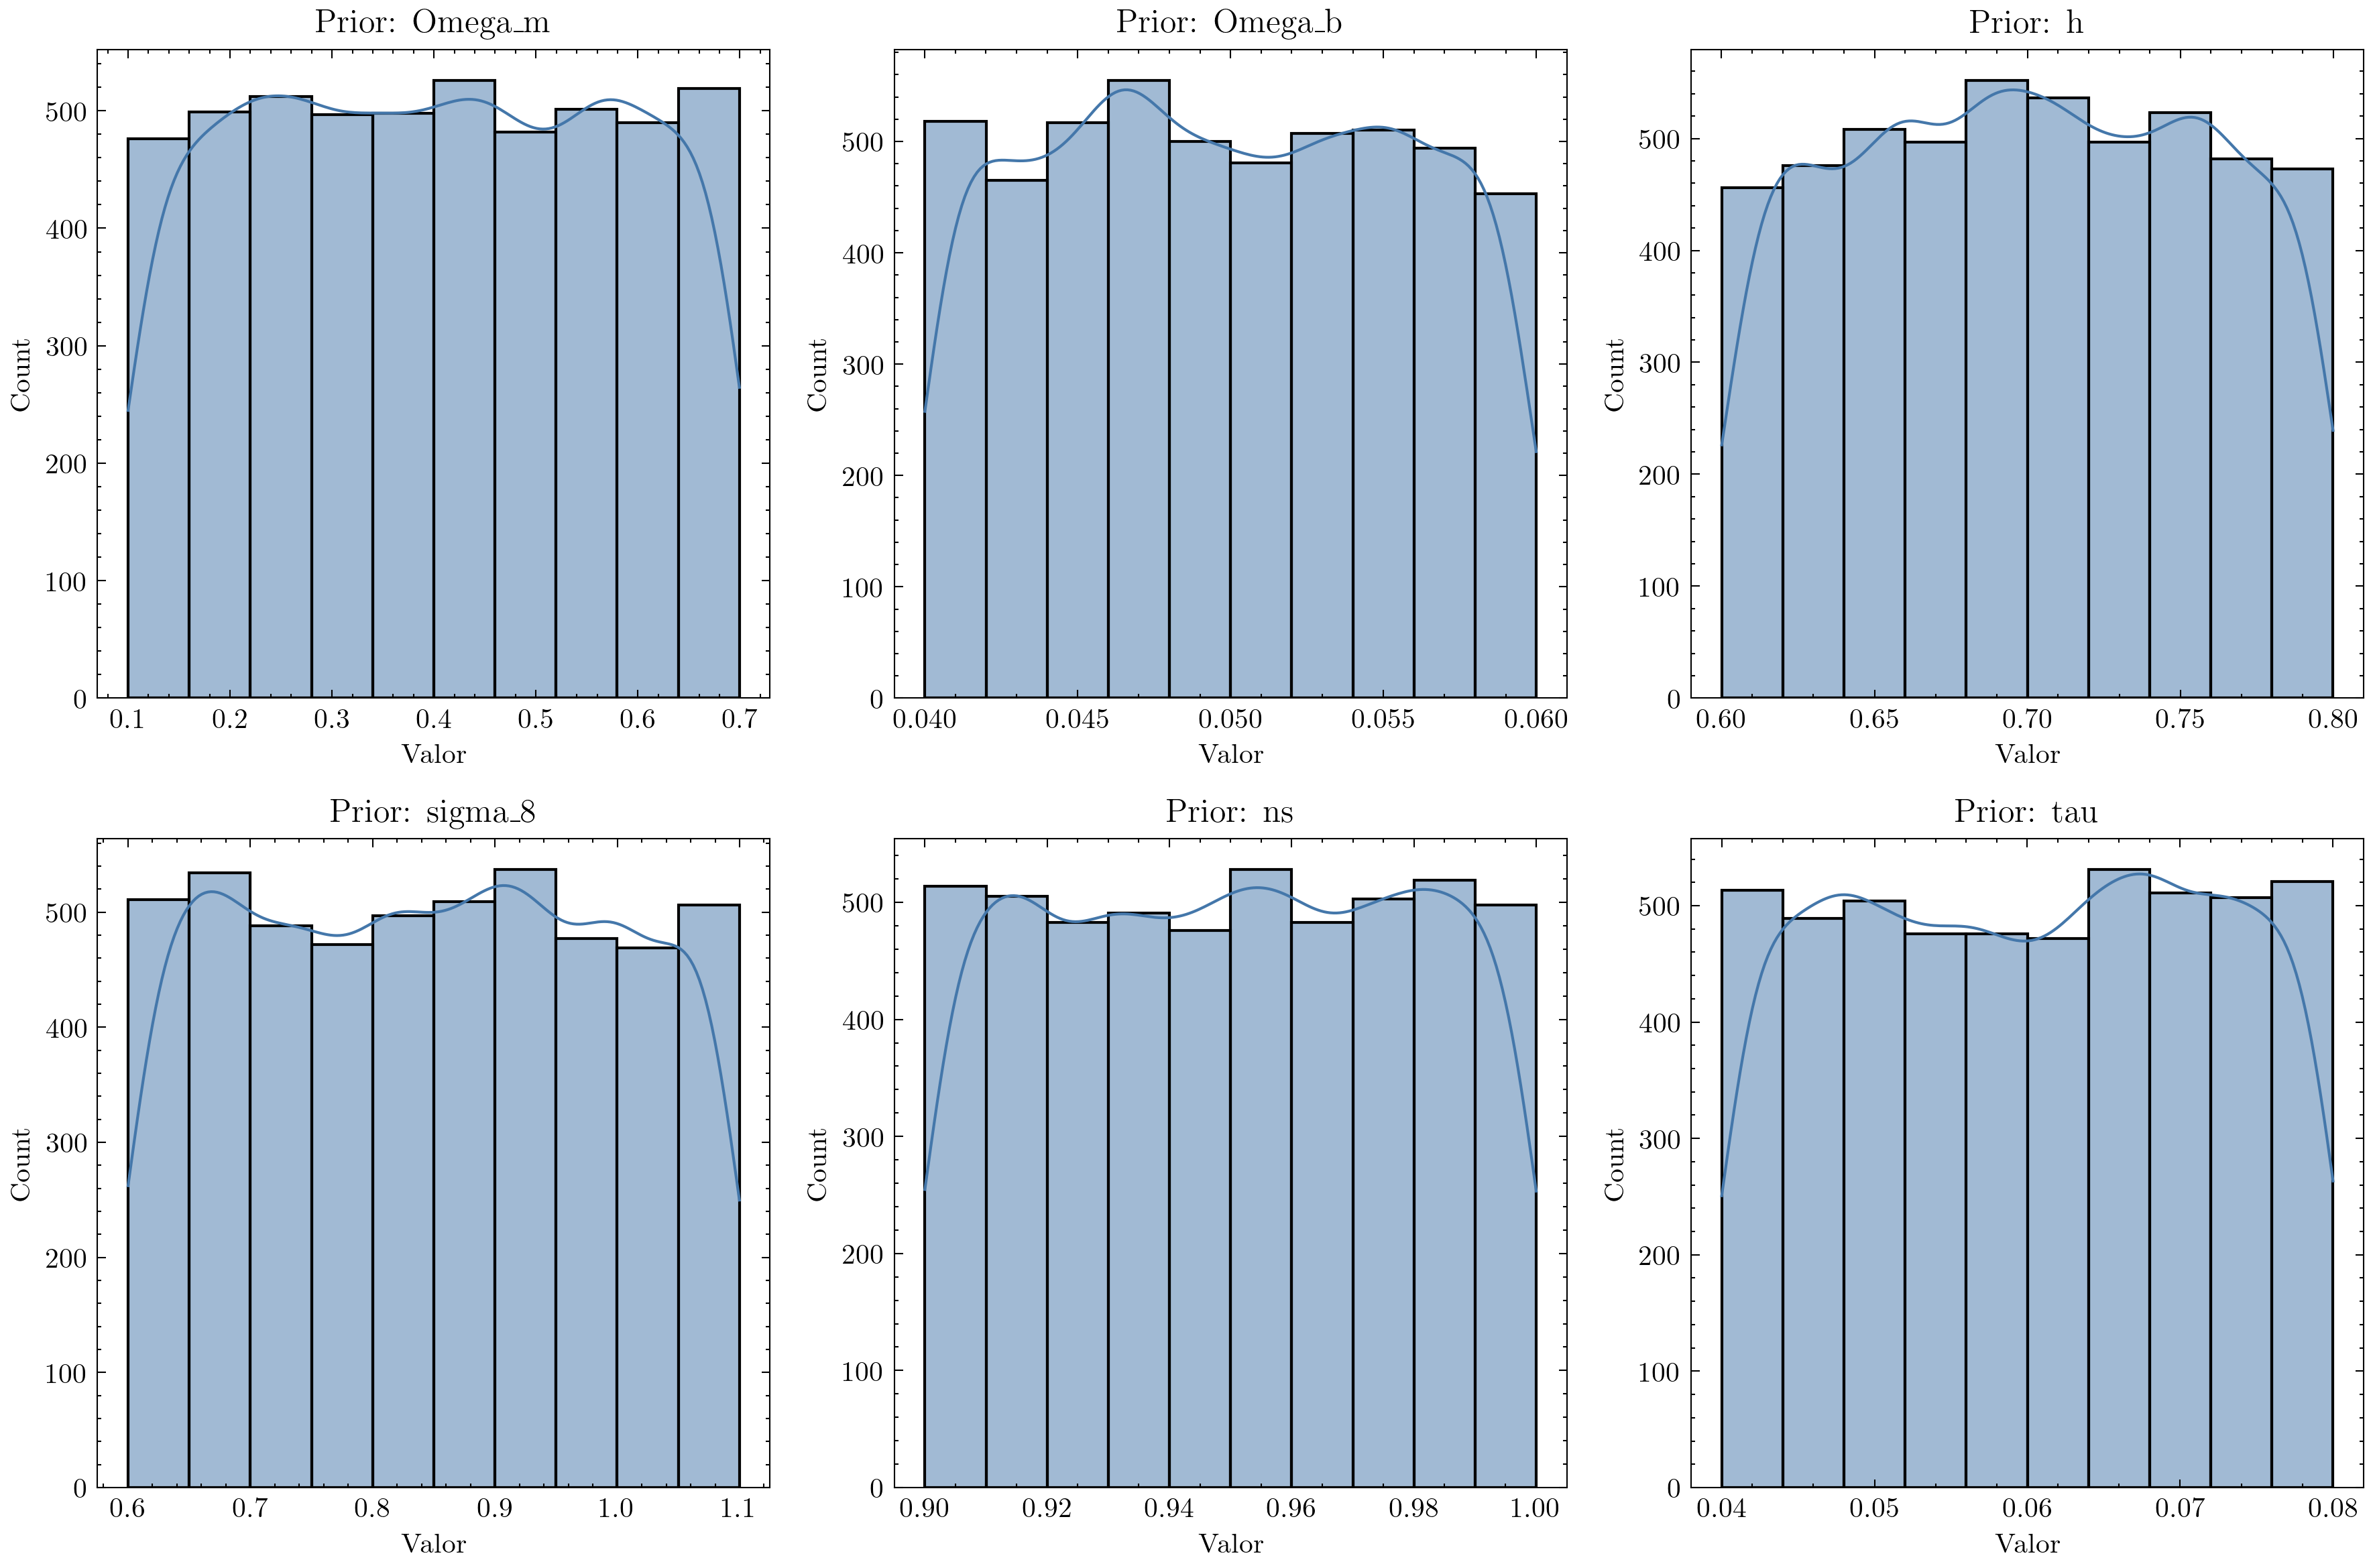

In [2]:
from src.inference.prior import get_prior
from src.inference.config import PARAM_RANGES

prior = get_prior()
print("\n=== Distribución Prior ===")
print(prior)

prior_samples = prior.sample((5000,))
param_names = list(PARAM_RANGES.keys())

plt.figure(figsize=(12, 8))
for i, name in enumerate(param_names):
    plt.subplot(2, 3, i+1)
    sns.histplot(prior_samples[:, i].numpy(), bins=10, kde=True)
    plt.title(f"Prior: {name}")
    plt.xlabel("Valor")
plt.tight_layout()
plt.show()

Simulación 1/5 - Parámetros: [0.46881703 0.04762026 0.7274229  0.83723056 0.9713594  0.06476145]
Simulación 2/5 - Parámetros: [0.36551958 0.04191537 0.7228315  0.6286639  0.9565714  0.06132916]
Simulación 3/5 - Parámetros: [0.33403048 0.05817697 0.7066737  0.95366967 0.97115976 0.04820137]
Simulación 4/5 - Parámetros: [0.28466964 0.05961718 0.6020523  0.83302045 0.94603753 0.07418619]
Simulación 5/5 - Parámetros: [0.37147912 0.05263318 0.69519967 0.71001333 0.9216605  0.05028332]

=== Prueba del Simulador ===
Input theta shape: torch.Size([5, 6])
Output spectra shape: torch.Size([5, 2401])


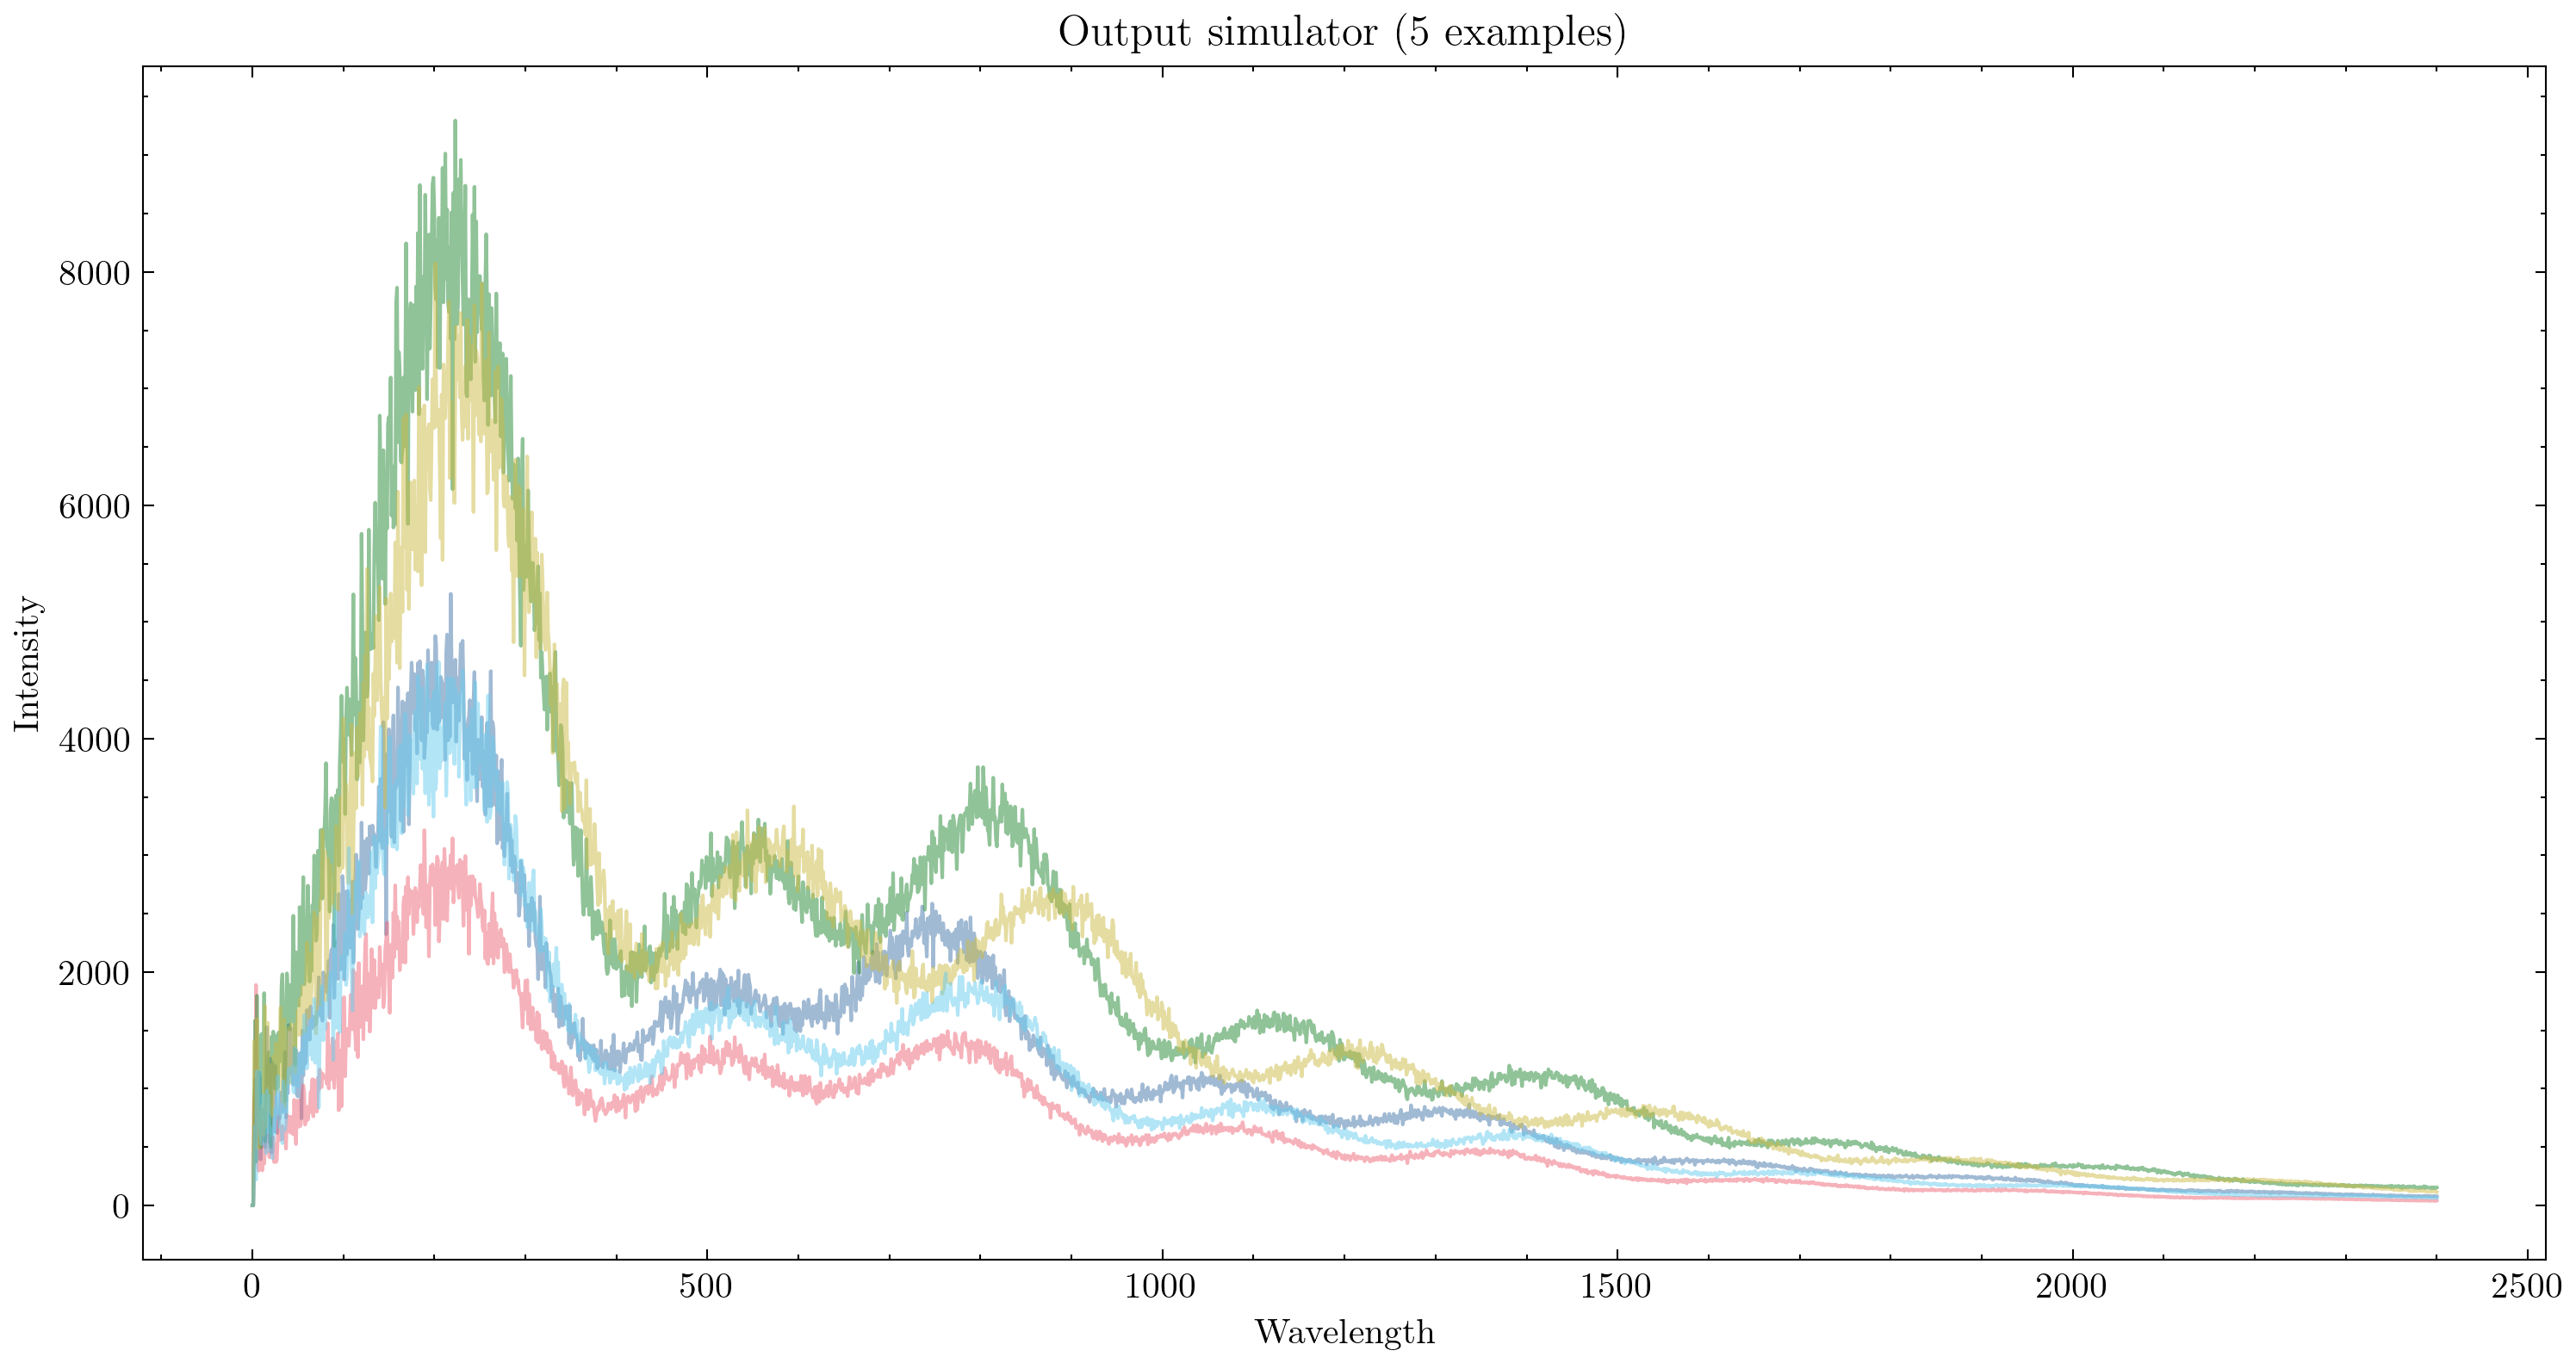

In [46]:
from src.inference.simulator import create_simulator

torch.manual_seed(2)

simulator = create_simulator()
test_theta = prior.sample((5,))
simulated_data = simulator(test_theta)

print("\n=== Prueba del Simulador ===")
print(f"Input theta shape: {test_theta.shape}")
print(f"Output spectra shape: {simulated_data.shape}")

plt.figure(figsize=(12, 6))
plt.plot(simulated_data.T, alpha=0.5)
plt.title("Output simulator (5 examples)")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.show()

In [47]:
print(simulated_data)

tensor([[   0.0000,    0.0000,  768.9919,  ...,   80.8296,   79.1636,
           77.4230],
        [   0.0000,    0.0000,  916.0157,  ...,   40.4519,   37.7175,
           41.2738],
        [   0.0000,    0.0000,  636.9244,  ...,  147.3202,  148.2897,
          152.7042],
        [   0.0000,    0.0000, 1407.6624,  ...,  117.1124,  118.9348,
          114.9968],
        [   0.0000,    0.0000,  355.7904,  ...,   66.9455,   65.4713,
           64.1092]])


In [44]:
def find_nan_simulations(tensor):
    nan_mask = torch.isnan(tensor).any(dim=1)
    nan_indices = torch.where(nan_mask)[0].tolist()
    
    return nan_indices

find_nan_simulations(simulated_data)


[]

In [ ]:
import os
from src.inference.utils import load_model

density_estimator = load_model(os.path.join("..", "results", "inference", "trained_model_3.pkl")) # 5000 sims -- CNN embedding

c:\users\julian\documents\cmb-sbi-inference\src\inference\utils.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


In [ ]:
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.inference import SNPE_C

embedding_net = CNNEmbedding(
    input_shape=(2401,),             
    in_channels=1,                   
    out_channels_per_layer=[16, 32, 64],  
    num_conv_layers=3,              
    num_linear_layers=2,           
    output_dim=8,                  
    kernel_size=5,                 
    pool_kernel_size=4             
)

neural_posterior = posterior_nn(model="maf", embedding_net=embedding_net)

inference = SNPE_C(
    prior=prior,
    density_estimator=neural_posterior,
    device="cpu"
)

posterior = inference.build_posterior(density_estimator)
print(posterior)


Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [14]:
true_parameter = torch.tensor([[0.315, 0.049, 0.674, 0.811, 0.965, 0.054]])
x_observed = simulator(true_parameter)

torch.manual_seed(40)
samples = posterior.set_default_x(x_observed).sample((20000,))

Simulación 1/1 - Parámetros: [0.315 0.049 0.674 0.811 0.965 0.054]






















Drawing 20000 posterior samples: 21589it [00:00, 24054.14it/s]


Drawing 20000 posterior samples:   0%|          | 0/20000 [01:47<?, ?it/s]


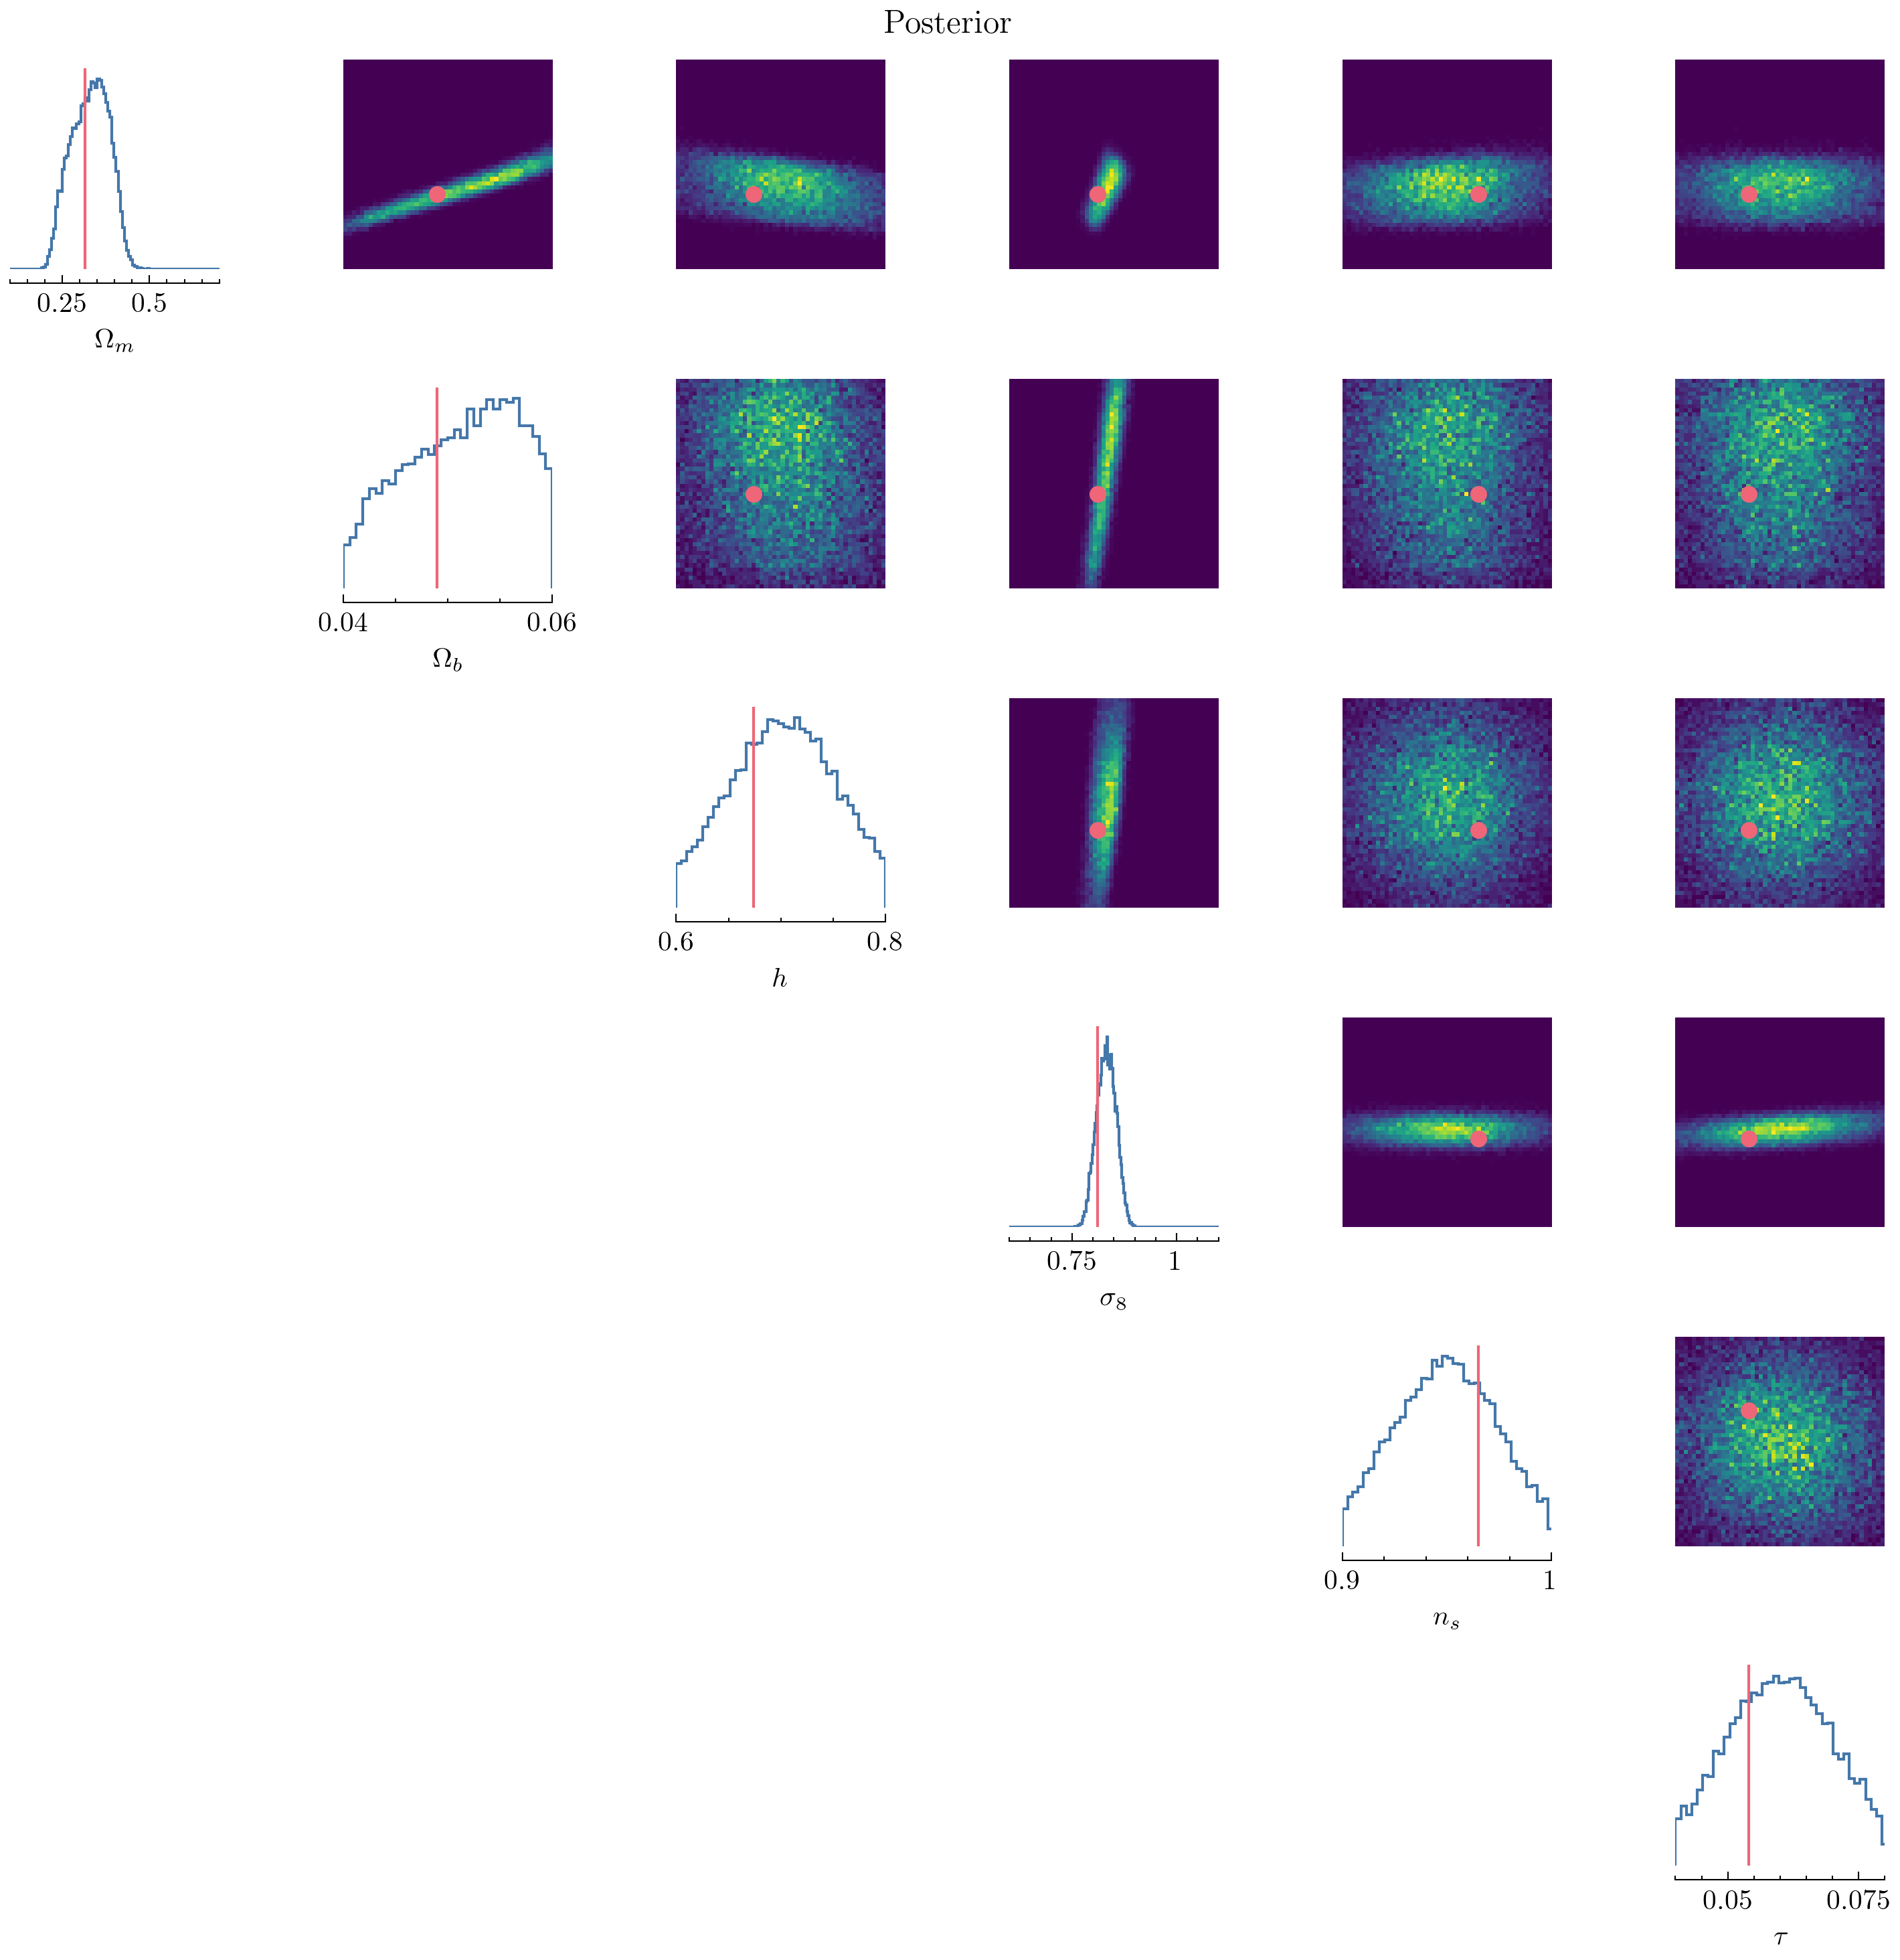

In [15]:
from sbi.analysis import pairplot

# --- LÍMITES DEL PRIOR ---
limits = torch.tensor([
    [0.1, 0.7],    
    [0.04, 0.06],  
    [0.6, 0.8],   
    [0.6, 1.1],    
    [0.9, 1.0],    
    [0.04, 0.08],  
])

param_names = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$\sigma_8$', r'$n_s$', r'$\tau$']

fig = pairplot(
    samples,
    points=true_parameter,
    figsize=(10, 10),
    limits=limits,
    labels=param_names
)

plt.suptitle('Posterior')
plt.tight_layout()
plt.show()

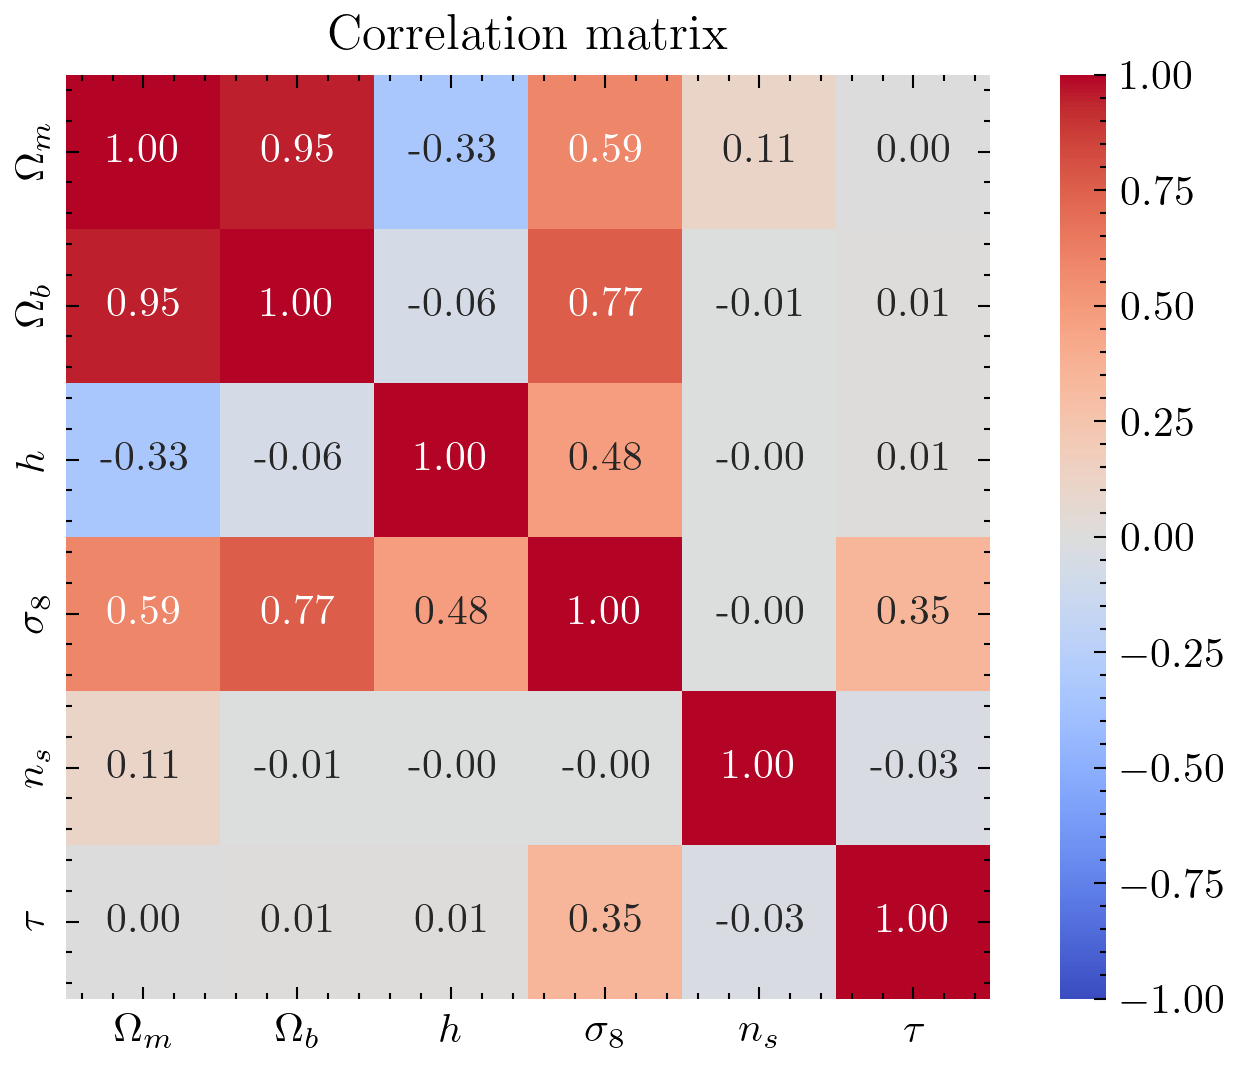

In [16]:
samples_np = samples.numpy()  
correlation_matrix = np.corrcoef(samples_np.T)  

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, xticklabels=param_names, yticklabels=param_names, vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()

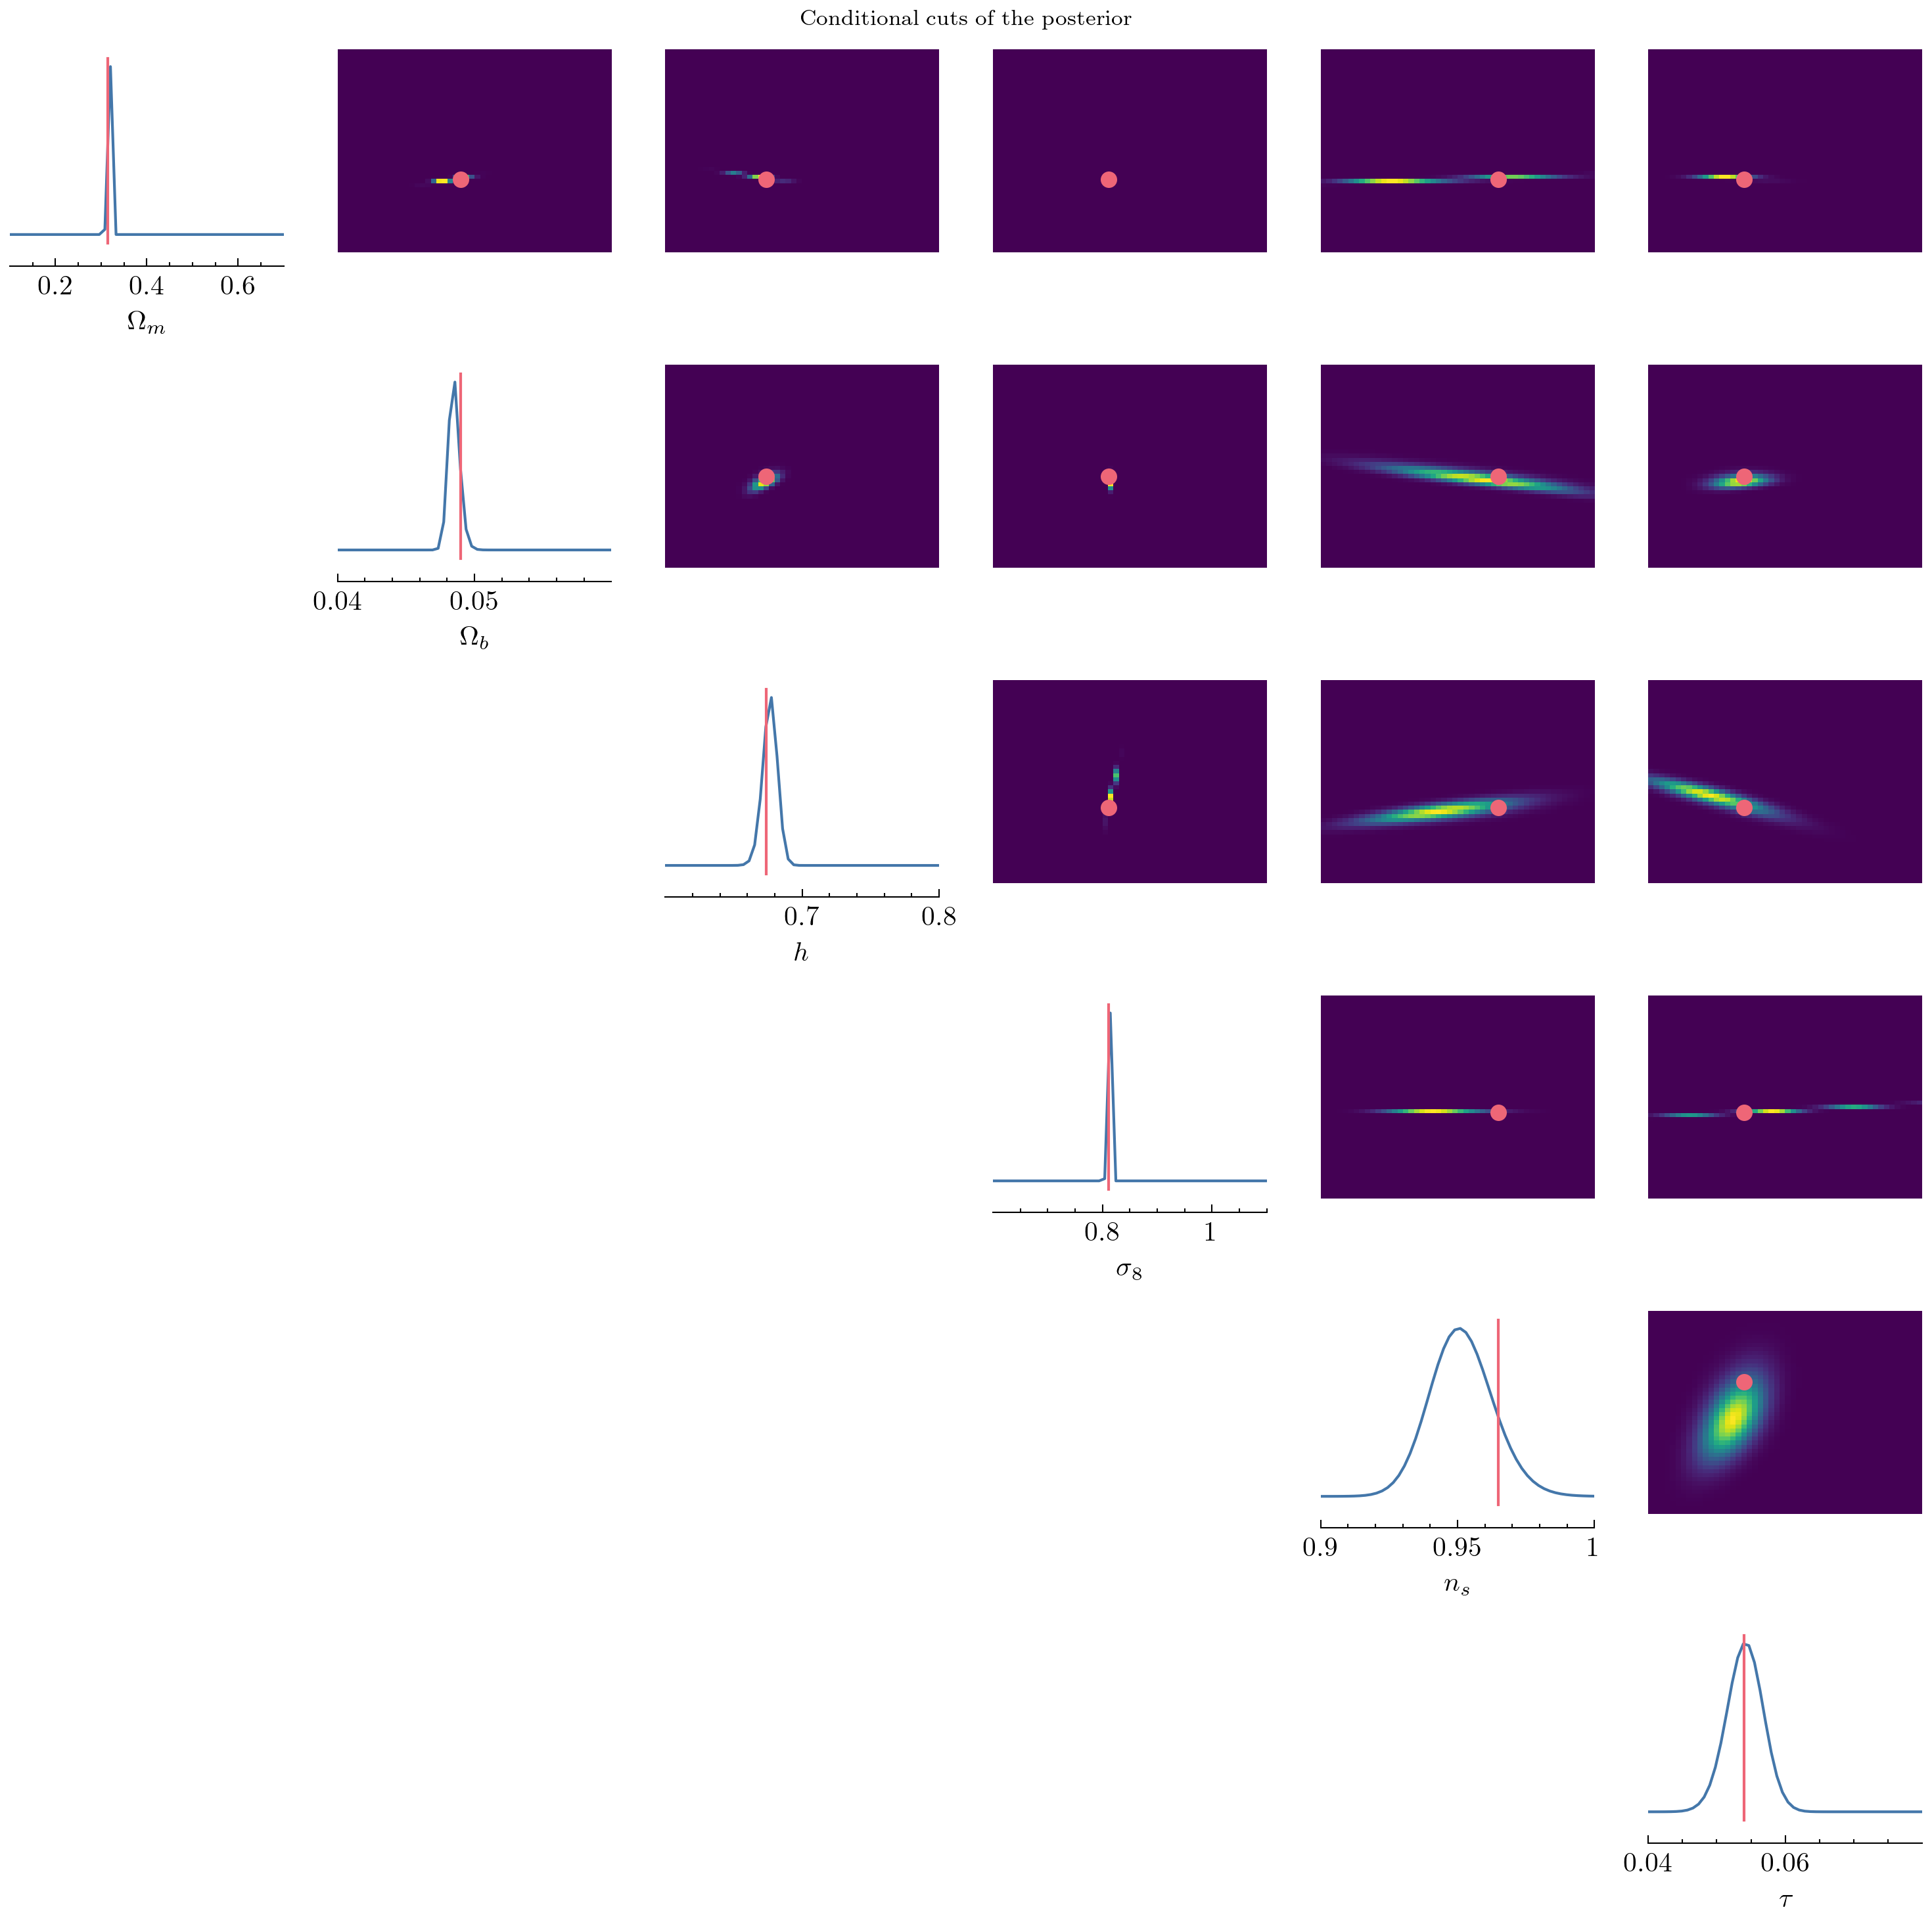

In [17]:
from sbi.analysis import conditional_pairplot

condition = true_parameter

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=limits,
    figsize=(10, 10),
    labels=param_names,
    points=true_parameter
)
plt.suptitle("Conditional cuts of the posterior", fontsize=8)
plt.tight_layout()
plt.show()

c:\Users\Julian\anaconda3\envs\sbi_env\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


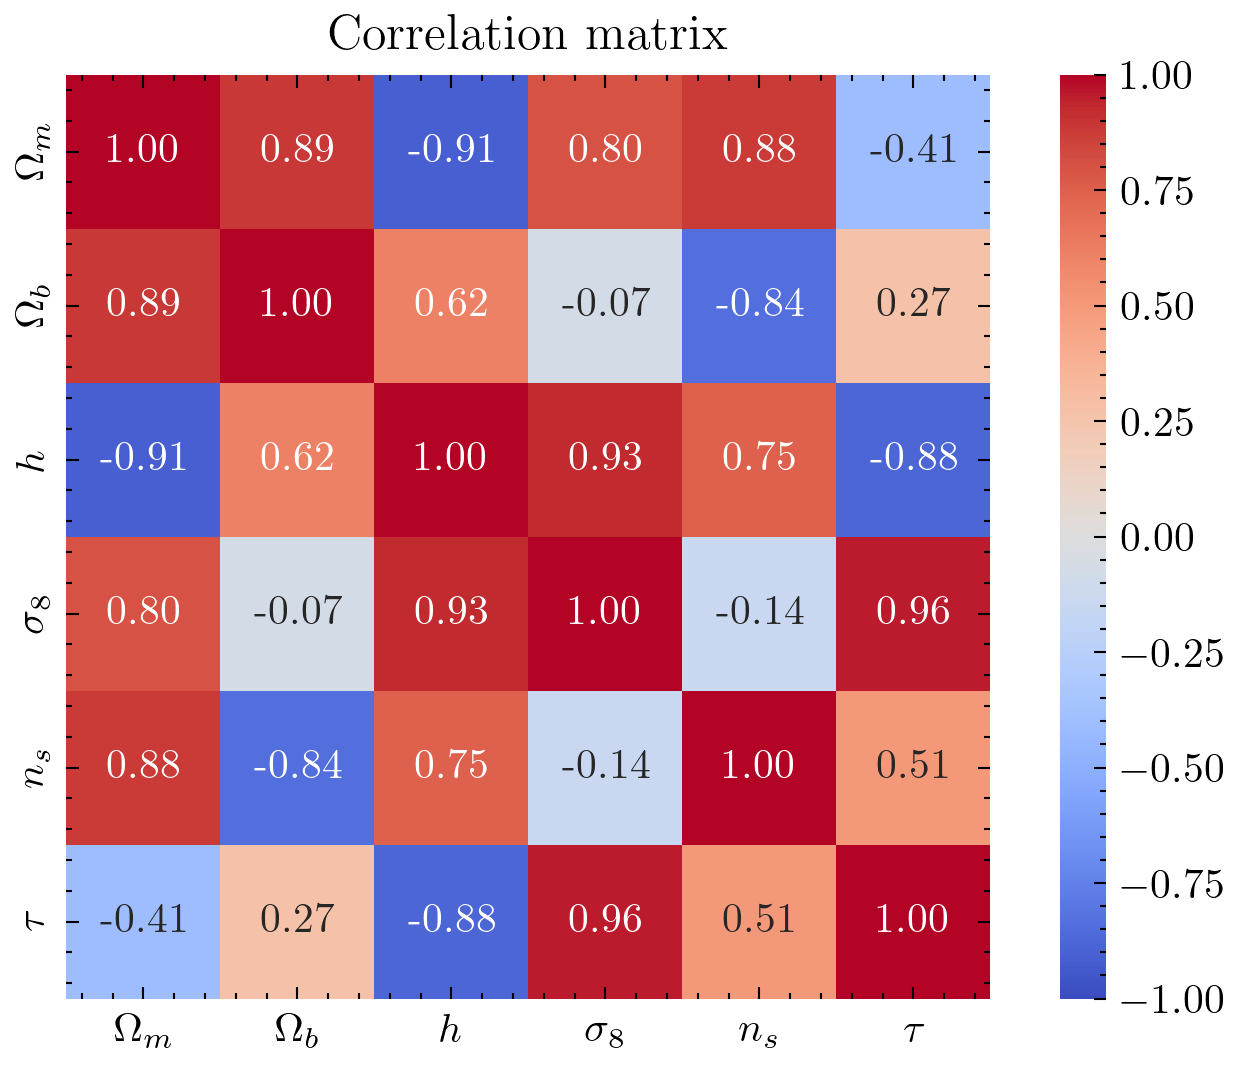

In [18]:
from sbi.analysis import conditional_corrcoeff

cond_corr = conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=limits
    
)

plt.figure(figsize=(6, 4))
sns.heatmap(cond_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, xticklabels=param_names, yticklabels=param_names, vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()